# 稳健性检验：日内稳定性与横截面异质性 (Robustness Checks)

## 0. 项目背景与目的
本 Notebook 旨在验证核心研究发现——**“买卖价差 (Spread) 调节挂单失衡 (LobImbalance) 预测方向的非线性机制”**——的稳健性与普适性。

为了排除数据挖掘 (Data Mining) 或局部过拟合的可能性，我们将从以下两个维度对模型结果进行压力测试：
1.  **日内稳定性 (Intraday Stability)**: 验证上午场 (AM) 与下午场 (PM) 的博弈逻辑是否一致，排除特定时段交易行为（如开盘抢单或收盘平仓）的干扰。
2.  **横截面异质性 (Cross-sectional Heterogeneity)**: 验证核心规律是否在不同特征（如高/低波动、大/小市值、高/低换手）的股票组别中普遍存在，证明这是微观市场的物理规律而非特定样本的巧合。

如果结论稳健，我们期望在所有子样本中均能观察到特征性的 **“Spread=1 动量 / Spread=2 反转 / Spread≥3 非线性”** 结构。

---

## 第一步：环境配置与全量数据加载
本模块负责初始化绘图风格、自动定位项目根目录，并加载核心数据文件：
1. **采样数据** (`sample_with_time.parquet`)：包含时序和基础特征。来自scripts/make_fast_sample.py。
2. **SHAP 矩阵** (`.npy`)：提取 LobImbalance 与 Micro_Mid_Spread 的交互值。
3. **个股特征** (`stock_features.csv`)：包含波动率、市值等异质性指标。来自scripts/fetch_stock_features.py。

最后将它们合并为一个主数据框 (`df_merged`)，作为后续所有检验的基础。

In [1]:
"""
功能：配置运行环境，加载采样数据、SHAP 交互值矩阵以及个股异质性特征，并完成数据合并。
输入：
    - data/processed/sample_with_time.parquet (采样数据)
    - data/processed/sample_with_time_shap.npy (SHAP 矩阵)
    - data/processed/stock_heterogeneity_features.csv (个股特征)
输出：
    - df_merged: 合并后的主数据框 (包含 Time, Stock, SHAP_Interaction, Daily_Amplitude 等)
    - shap_values_all: 原始 SHAP 矩阵 (用于切片索引)
逻辑：
    1. 自动定位项目根目录。
    2. 加载 Parquet 和 NPY 文件。
    3. 提取 LobImbalance 与 Micro_Mid_Spread 的交互值，存入 df['SHAP_Interaction']。
    4. 读取 CSV 特征文件，清洗 Stock 代码格式，执行 Inner Merge。
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import datetime

# --- 全局配置 ---
DPI = 120
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']  # 适配中英文环境
plt.rcParams['axes.unicode_minus'] = False

# --- 路径定位 ---
def find_project_root(current_path, marker='results'):
    current_path = os.path.abspath(current_path)
    if os.path.exists(os.path.join(current_path, marker)): return current_path
    parent = os.path.dirname(current_path)
    if parent == current_path: raise FileNotFoundError("未找到项目根目录")
    return find_project_root(parent, marker)

try:
    PROJECT_ROOT = find_project_root(os.getcwd())
    print(f"✅ 项目根目录: {PROJECT_ROOT}")
except:
    PROJECT_ROOT = '/Users/day/Desktop/书架/大三上/LOB_Spread_Regime' # Fallback
    print(f"⚠️ 使用硬编码路径: {PROJECT_ROOT}")

# 文件路径
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time.parquet')
SHAP_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed', 'sample_with_time_shap.npy')
FEATURE_FILE = os.path.join(PROJECT_ROOT, 'data', 'processed', 'stock_heterogeneity_features.csv')

# 特征列表 (索引对应)
FEATURE_COLS = [
    'Accum_Vol_Diff', 'VolumeMax', 'VolumeAll', 'Immediacy', 
    'Depth_Change', 'LobImbalance', 'DeepLobImbalance', 
    'Relative_Spread', 'Micro_Mid_Spread', 'PastReturn', 
    'Lambda', 'Volatility', 'AutoCov'
]

# --- 加载与合并 ---
print("\n>>> 1. 正在加载 SHAP 数据...")
if not os.path.exists(DATA_PATH) or not os.path.exists(SHAP_PATH):
    raise FileNotFoundError("基础数据缺失，请先运行 01_ReproduceSHAPPlot.ipynb")

df = pd.read_parquet(DATA_PATH)
shap_values_all = np.load(SHAP_PATH)

# 预计算交互效应 (LobImbalance vs Micro_Mid_Spread)
idx_x = FEATURE_COLS.index('LobImbalance')
idx_y = FEATURE_COLS.index('Micro_Mid_Spread')
# 注意: shap_values[sample, i, j] 是特征 i 和 j 的交互贡献，通常是对称的，需 * 2 得到总效应
df['SHAP_Interaction'] = shap_values_all[:, idx_x, idx_y] * 2

print(">>> 2. 正在加载个股异质性特征...")
if os.path.exists(FEATURE_FILE):
    df_features = pd.read_csv(FEATURE_FILE, dtype={'Stock': str})
    
    # 格式化 Stock 代码 (6位字符串) 以确保 merge 成功
    df['Stock'] = df['Stock'].astype(str).str.zfill(6)
    df_features['Stock'] = df_features['Stock'].astype(str).str.zfill(6)
    
    # 合并
    df_merged = pd.merge(df, df_features, on='Stock', how='inner')
    print(f"    特征文件已加载: {df_features.columns.tolist()}")
    print(f"    合并后样本数: {len(df_merged)} (原始: {len(df)})")
else:
    print("⚠️ 警告: 未找到个股特征文件，将跳过横截面检验。")
    df_merged = df.copy()

✅ 项目根目录: /Users/day/Desktop/书架/大三上/LOB_Spread_Regime

>>> 1. 正在加载 SHAP 数据...
>>> 2. 正在加载个股异质性特征...
    特征文件已加载: ['Stock', 'Daily_Price', 'Daily_Amplitude', 'Daily_Turnover', 'Daily_PE', 'Daily_FloatMV']
    合并后样本数: 9910 (原始: 10000)


## 第二步：定义通用绘图工具
为了保证检验结果的可比性，我们定义了统一的绘图函数 `plot_comparison_panel`。
该函数实现了以下关键逻辑：
- **自动去极值**：剔除 Micro_Mid_Spread 上下 0.5% 的极端值，防止离群点压缩可视化空间。
- **统一色标**：基于两组数据的整体分布设定颜色范围（98% 分位数），确保左右两图的颜色深浅具有可比性。

In [2]:
"""
功能：定义通用的绘图函数，用于绘制对比散点图。
包含函数：
    - plot_interaction_scatter: 绘制单个子图的核心逻辑。
    - plot_comparison_panel: 绘制左右对比图 (Panel A vs Panel B)。
"""

def plot_interaction_scatter(ax, df_subset, title, c_limit):
    """
    在指定的 Axes 上绘制 SHAP 交互散点图。
    """
    # 数据清洗：剔除 Micro_Mid_Spread 上下 0.5% 的极端值以优化显示
    col_name = 'Micro_Mid_Spread'
    lb = df_subset[col_name].quantile(0.005)
    ub = df_subset[col_name].quantile(0.995)
    mask = (df_subset[col_name] >= lb) & (df_subset[col_name] <= ub)
    plot_df = df_subset[mask]
    
    sc = ax.scatter(
        x=plot_df['LobImbalance'], 
        y=plot_df['Micro_Mid_Spread'], 
        c=plot_df['SHAP_Interaction'], 
        cmap='seismic', 
        s=8, alpha=0.65,
        vmin=-c_limit, vmax=c_limit,
        edgecolor='none'
    )
    
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('LobImbalance', fontsize=11)
    ax.set_ylabel('Micro_Mid_Spread', fontsize=11)
    ax.axhline(0, c='black', ls=':', alpha=0.4)
    ax.axvline(0, c='black', ls=':', alpha=0.4)
    
    # 添加样本量标注
    ax.text(0.05, 0.95, f"N={len(plot_df)}", transform=ax.transAxes, 
            fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    return sc

def plot_comparison_panel(df_left, title_left, df_right, title_right, main_title):
    """
    绘制左右对比图 (用于 AM vs PM 或 Q1 vs Q5)。
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi=DPI)
    
    # 计算统一的颜色范围 (基于两组数据的 98% 分位数)
    all_shap = np.concatenate([df_left['SHAP_Interaction'], df_right['SHAP_Interaction']])
    c_max = np.percentile(np.abs(all_shap), 98)
    
    # 绘制左图
    plot_interaction_scatter(axes[0], df_left, title_left, c_max)
    # 绘制右图
    sc = plot_interaction_scatter(axes[1], df_right, title_right, c_max)
    
    # 共享 Colorbar
    cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('SHAP Interaction (Red=Momentum, Blue=Reversal)', fontsize=10)
    
    plt.suptitle(main_title, fontsize=16, y=1.02)
    plt.show()

## 第三步：执行全量稳健性检验
本模块依次执行两类核心检验，验证“五段式”非线性规律的普适性：

1. **任务 1：日内稳定性 (Intraday Stability)**
   - 对比 **上午场 (AM)** 与 **下午场 (PM)** 的交互模式，排除开盘/收盘特定时段的偶然性。

2. **任务 2：横截面异质性 (Cross-sectional Heterogeneity)**
   - 遍历 **波动率、市值、PE、换手率、股价** 5 个因子。
   - 对每个因子进行五分位分组 (Quintile)，对比 **最低组 (Q1)** 与 **最高组 (Q5)** 的 SHAP 图形态，验证规律在不同类型股票中的鲁棒性。


>>> [Task 1] Running Intraday Stability Check...
    AM Samples: 5577 | PM Samples: 4333


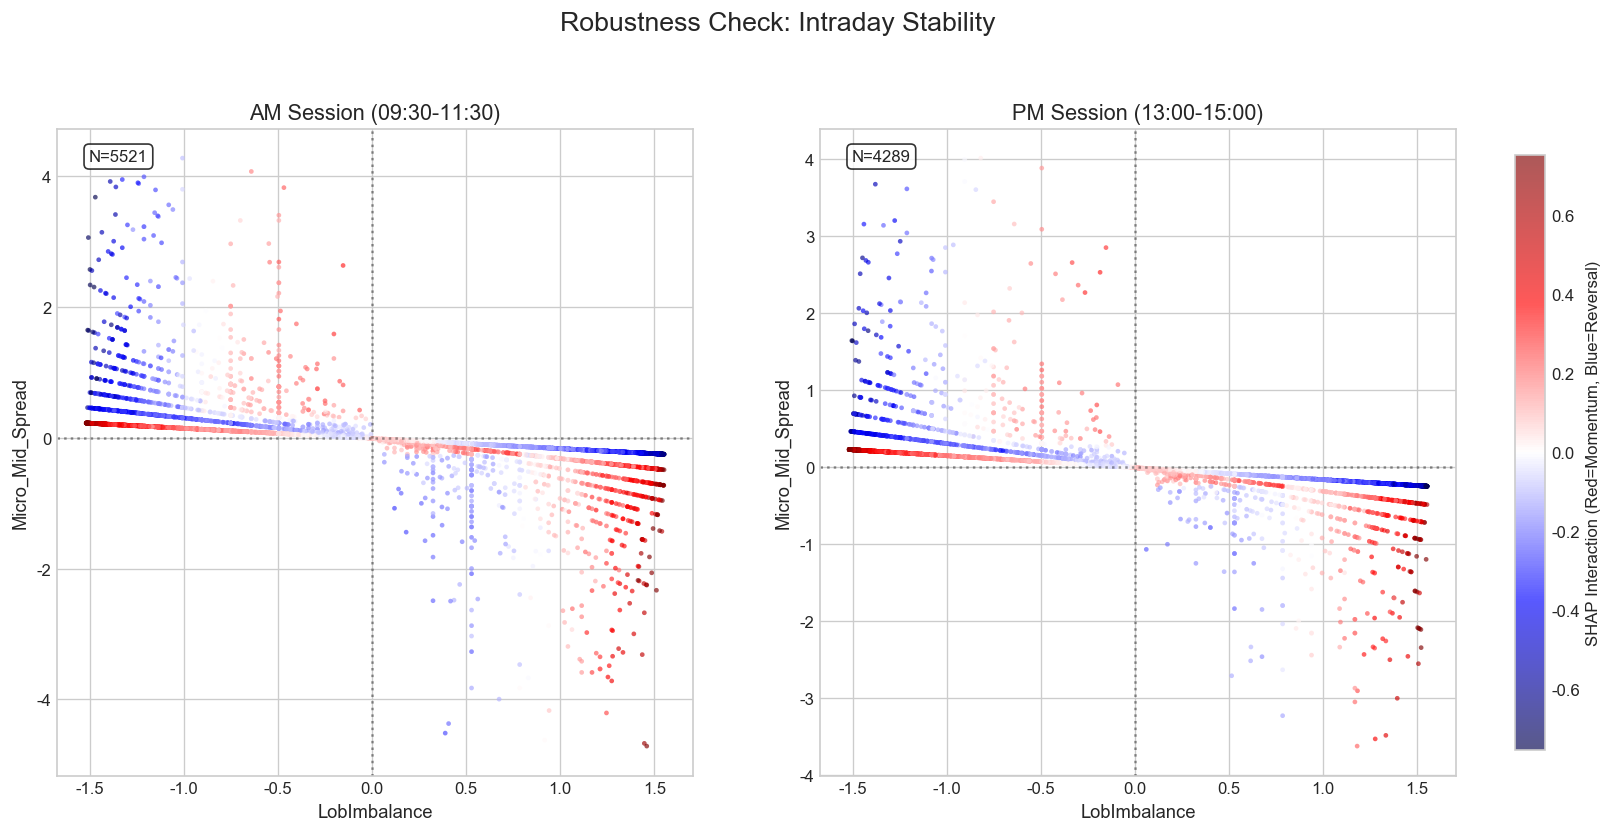


>>> [Task 2] Running Cross-sectional Heterogeneity Check...

--- Analyzing Factor: Daily_Amplitude ---
    Q1 (Low):  N=1999 | Max < 1.9004
    Q5 (High): N=1917 | Min > 3.6728


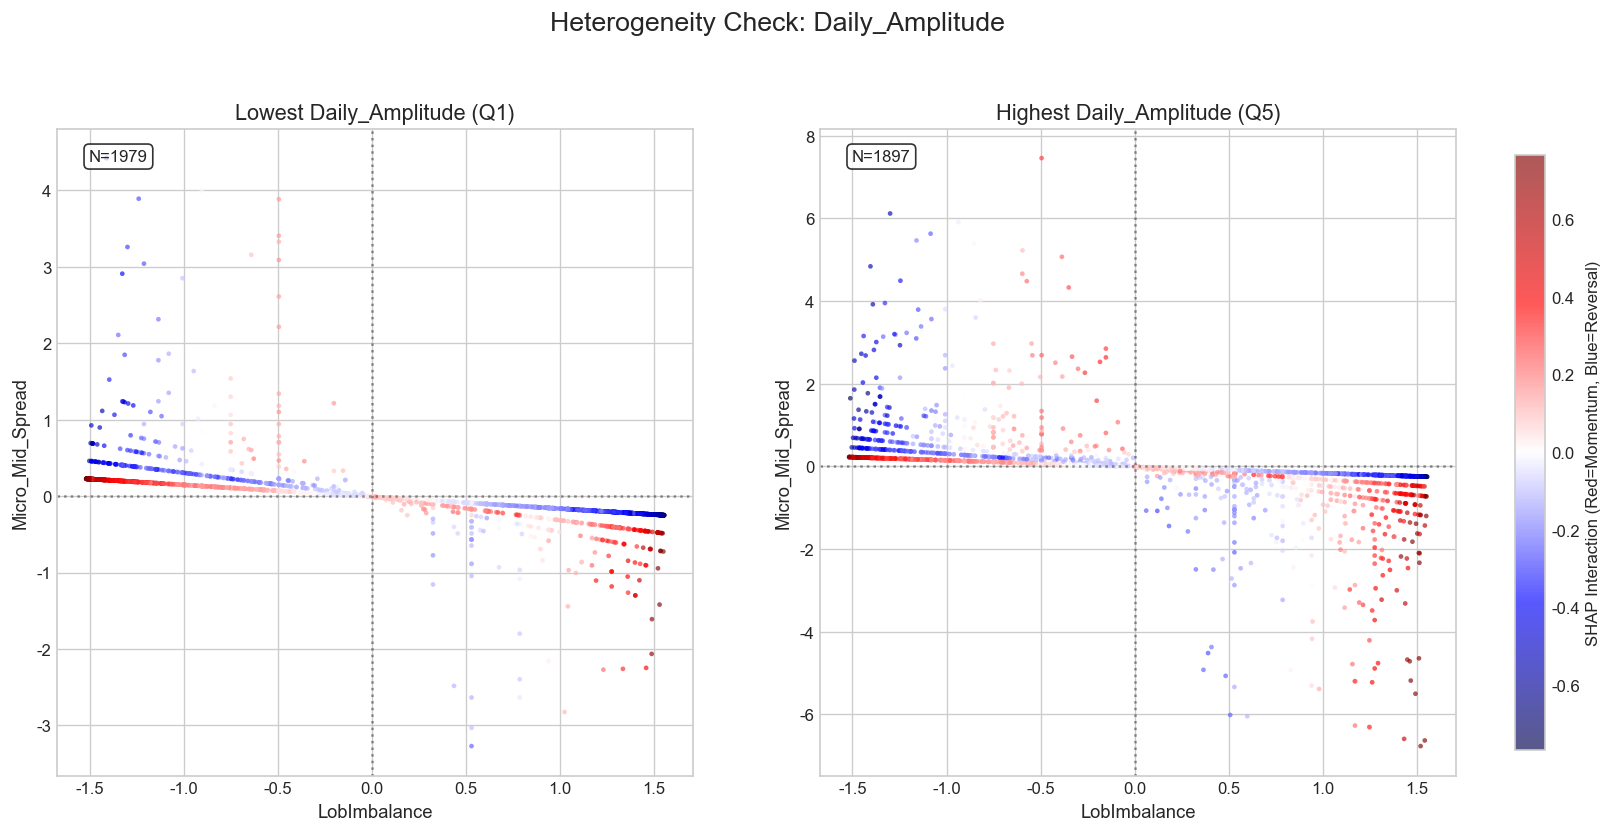


--- Analyzing Factor: Daily_FloatMV ---
    Q1 (Low):  N=2003 | Max < 62203258986.0000
    Q5 (High): N=1934 | Min > 240714342500.0000


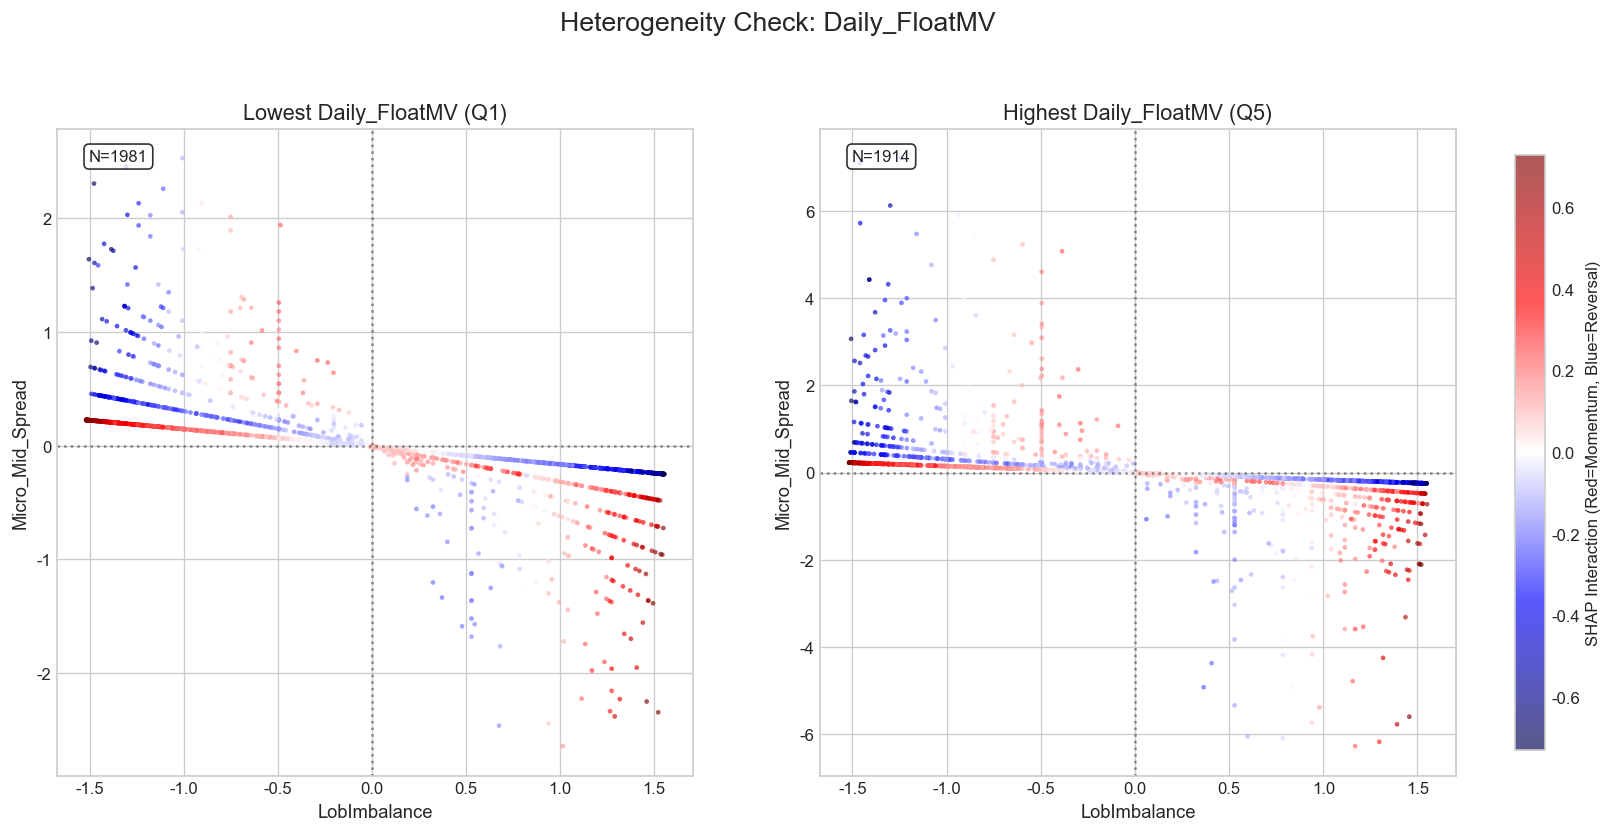


--- Analyzing Factor: Daily_PE ---
    Q1 (Low):  N=1989 | Max < 12.6900
    Q5 (High): N=1977 | Min > 60.4300


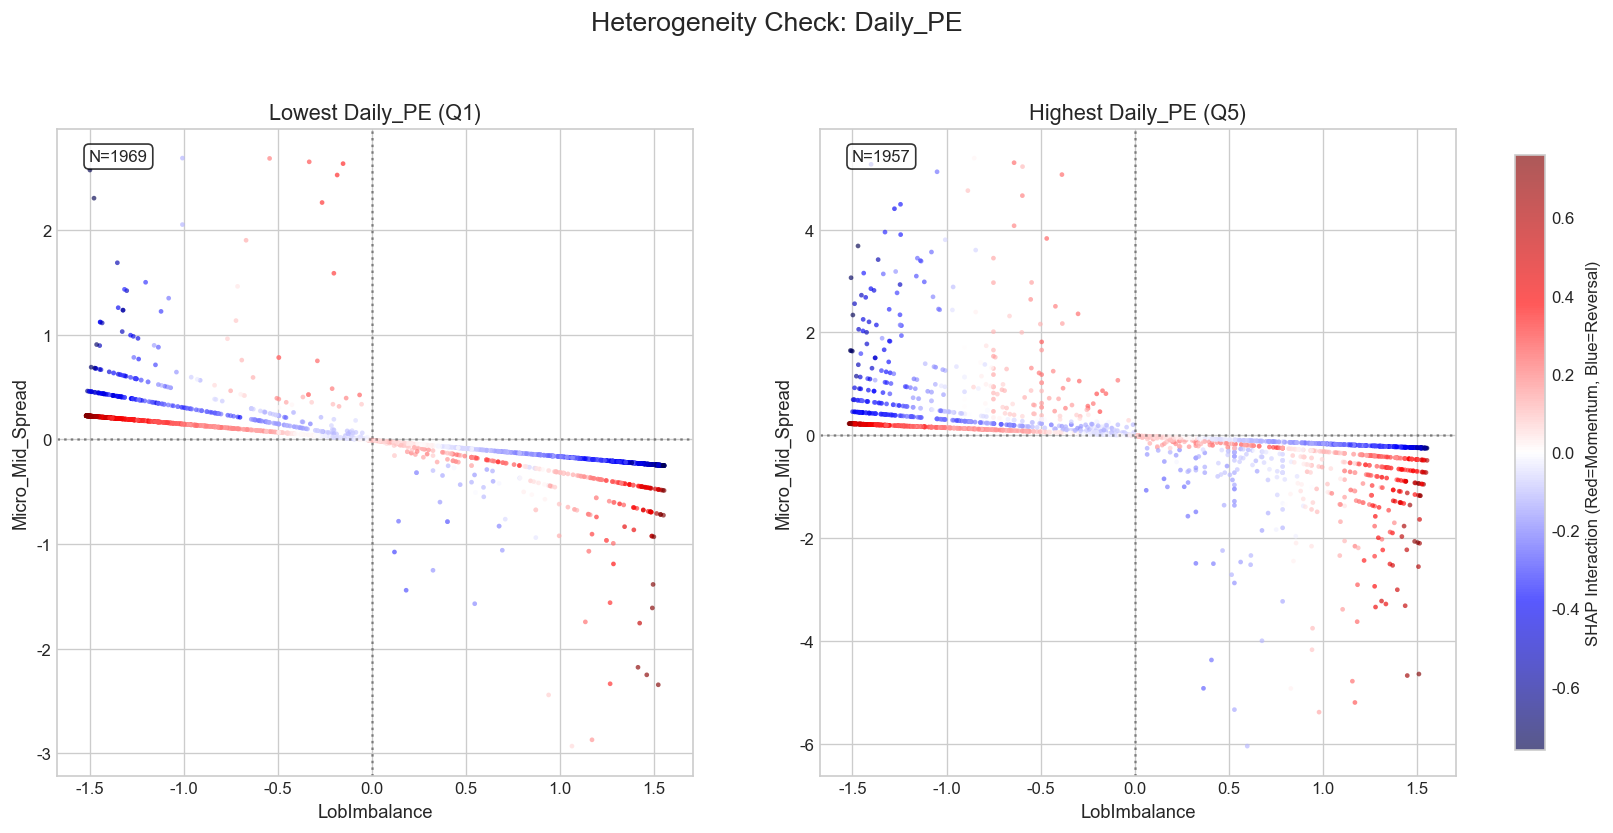


--- Analyzing Factor: Daily_Turnover ---
    Q1 (Low):  N=2002 | Max < 0.5236
    Q5 (High): N=1953 | Min > 2.4152


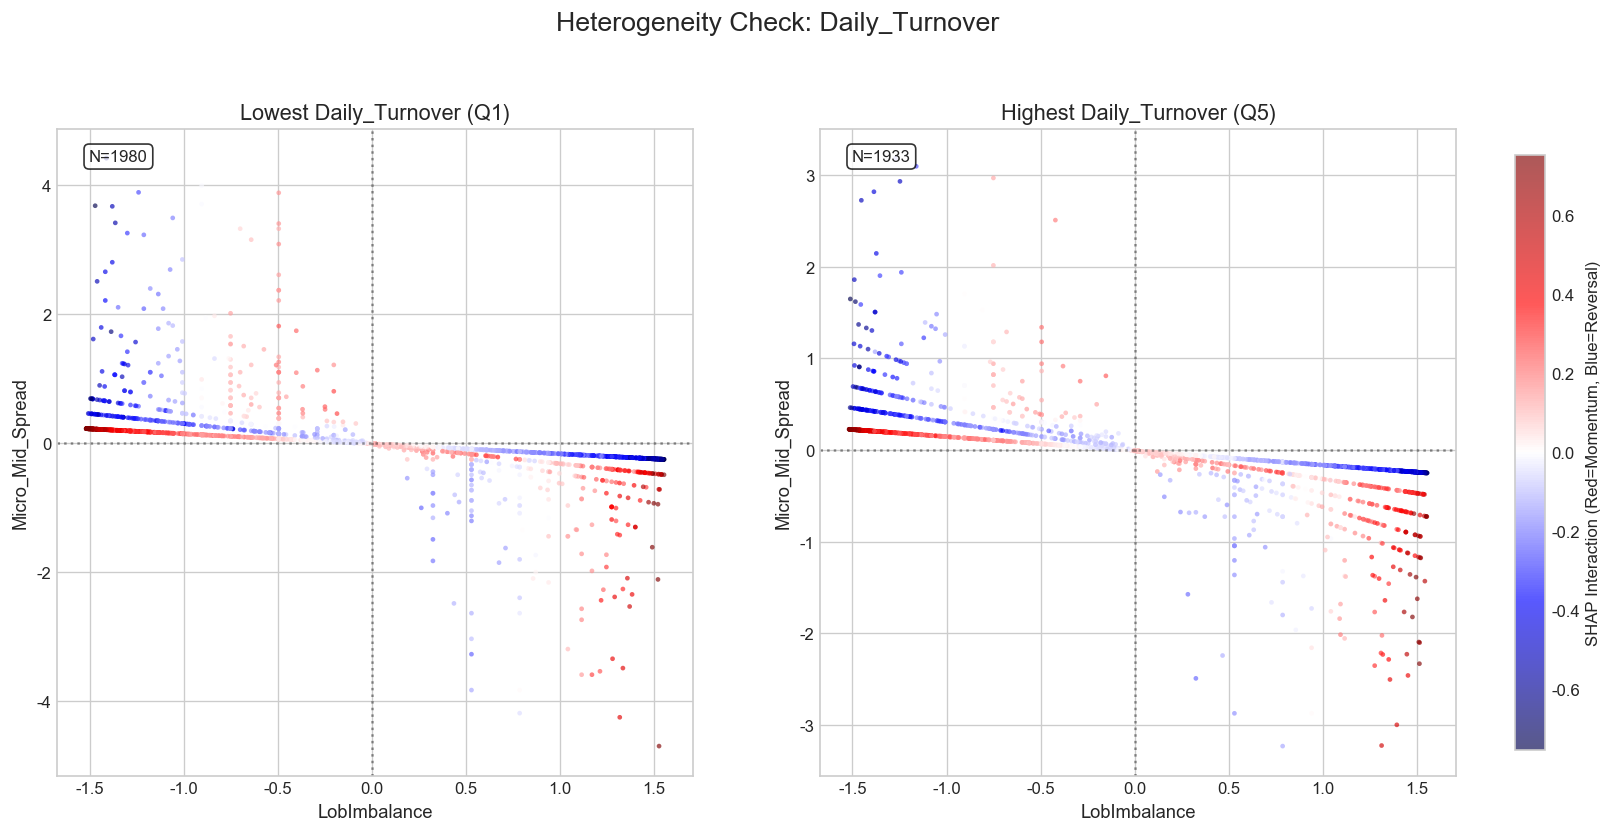


--- Analyzing Factor: Daily_Price ---
    Q1 (Low):  N=1997 | Max < 19.6572
    Q5 (High): N=1920 | Min > 124.4312


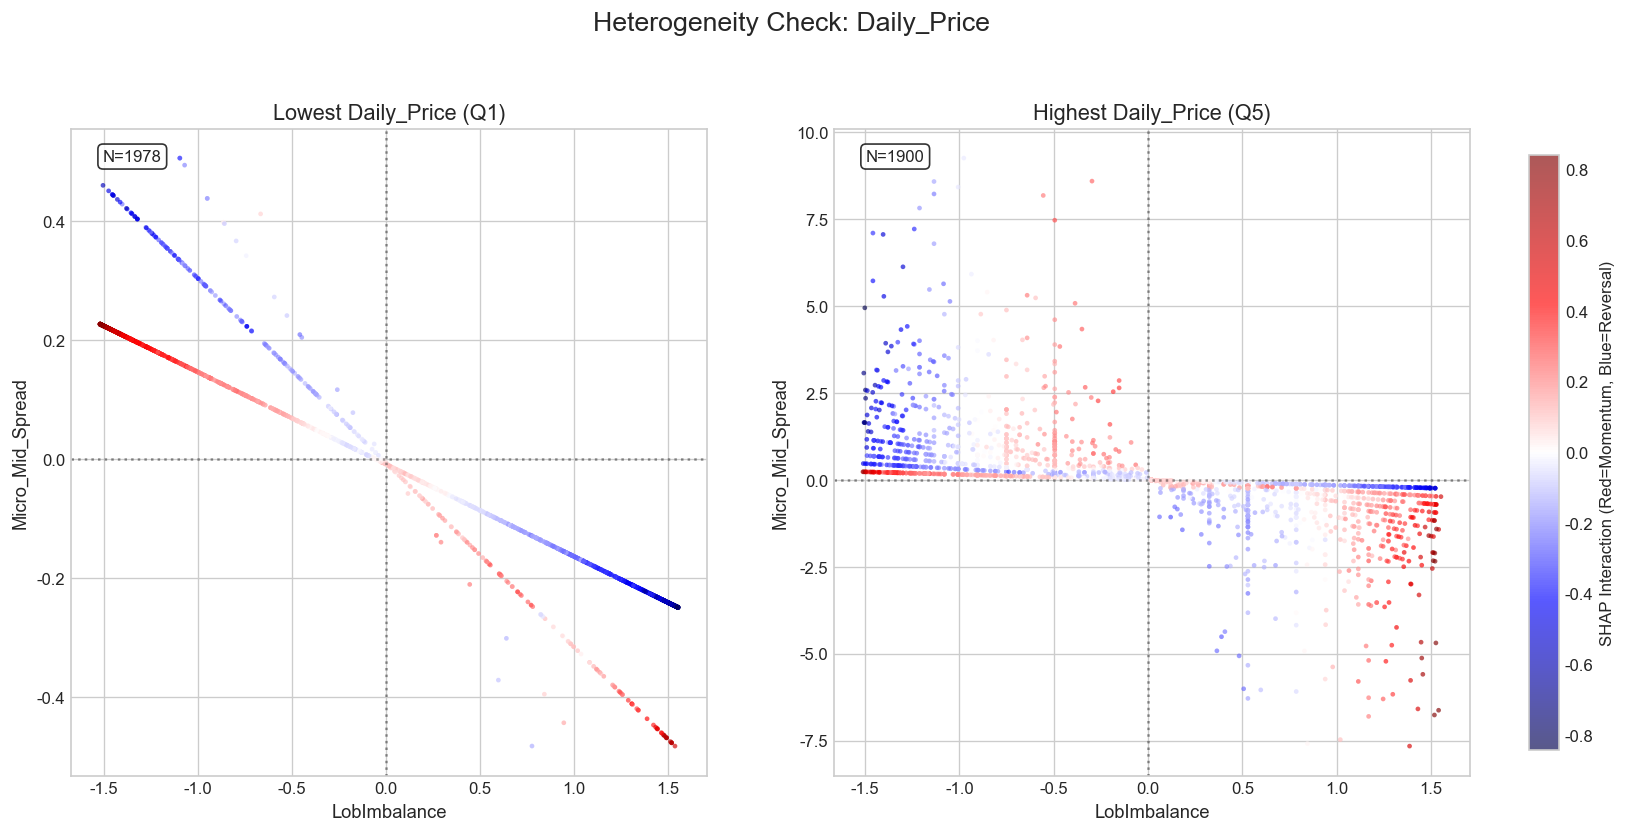


✅ 所有检验完成。


In [3]:
"""
功能：执行所有稳健性检验任务。
逻辑：
    1. 日内稳定性检验 (Intraday Stability):
       - 按 Time 列切分为 AM (<=11:30) 和 PM (>=13:00)。
       - 调用绘图函数展示 AM vs PM 的对比。
    2. 横截面异质性检验 (Cross-sectional Heterogeneity):
       - 遍历 5 个核心指标 (振幅, 市值, PE, 股价, 换手)。
       - 对每个指标进行五分位分组 (Quintile Cut)。
       - 对比 Q1 (最低组) 与 Q5 (最高组) 的 SHAP 交互模式。
"""

# ================= 任务 1: 日内稳定性 (AM vs PM) =================
print("\n>>> [Task 1] Running Intraday Stability Check...")

if 'Time' in df_merged.columns:
    # 确保时间列格式正确
    try:
        times = pd.to_datetime(df_merged['Time'], format='%H:%M:%S').dt.time
    except:
        times = pd.to_datetime(df_merged['Time']).dt.time
        
    mask_am = times <= datetime.time(11, 30)
    mask_pm = times >= datetime.time(13, 0)
    
    df_am = df_merged[mask_am]
    df_pm = df_merged[mask_pm]
    
    print(f"    AM Samples: {len(df_am)} | PM Samples: {len(df_pm)}")
    
    if len(df_am) > 0 and len(df_pm) > 0:
        plot_comparison_panel(
            df_am, "AM Session (09:30-11:30)", 
            df_pm, "PM Session (13:00-15:00)", 
            "Robustness Check: Intraday Stability"
        )
    else:
        print("    ⚠️ 时间切分后数据不足，跳过绘图。")
else:
    print("    ⚠️ 缺少 Time 列，跳过日内检验。")


# ================= 任务 2: 横截面异质性 (Q1 vs Q5) =================
print("\n>>> [Task 2] Running Cross-sectional Heterogeneity Check...")

# 待检验的异质性因子
factors = [
    'Daily_Amplitude',   # 波动率 (最关键)
    'Daily_FloatMV',     # 市值 (大票 vs 小票)
    'Daily_PE',          # 估值 (成长 vs 价值)
    'Daily_Turnover',    # 活跃度 (机构 vs 散户)
    'Daily_Price'        # 低价股 vs 高价股
]

for factor in factors:
    if factor not in df_merged.columns:
        continue
        
    print(f"\n--- Analyzing Factor: {factor} ---")
    valid_df = df_merged.dropna(subset=[factor]).copy()
    
    try:
        # 五分位分组
        valid_df['Group'] = pd.qcut(valid_df[factor], q=5, labels=['Q1','Q2','Q3','Q4','Q5'])
        
        df_q1 = valid_df[valid_df['Group'] == 'Q1']
        df_q5 = valid_df[valid_df['Group'] == 'Q5']
        
        # 获取分组边界值以便展示
        val_q1 = valid_df[valid_df['Group']=='Q1'][factor].max()
        val_q5 = valid_df[valid_df['Group']=='Q5'][factor].min()
        
        print(f"    Q1 (Low):  N={len(df_q1)} | Max < {val_q1:.4f}")
        print(f"    Q5 (High): N={len(df_q5)} | Min > {val_q5:.4f}")
        
        plot_comparison_panel(
            df_q1, f"Lowest {factor} (Q1)", 
            df_q5, f"Highest {factor} (Q5)", 
            f"Heterogeneity Check: {factor}"
        )
        
    except Exception as e:
        print(f"    ❌ Error processing {factor}: {e}")

print("\n✅ 所有检验完成。")